In [1]:
import nocd
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse as sp
import torch
import torch.nn as nn
import torch.nn.functional as F
from nocd.nn import models_deep
from nocd.utils import to_sparse_tensor

from sklearn.preprocessing import normalize

%matplotlib inline

torch.set_default_tensor_type(torch.cuda.FloatTensor)

# Defining and training the model

Load the dataset
 - `A` (adjacency matrix) is a `scipy.sparse.csr_matrix` of size `[N, N]`
 - `X` (attribute matrix) is a `scipy.sparse.csr_matrix` of size `[N, D]`
 - `Z_gt` (binary community affiliation matrix) is a `np.ndarray` of size `[N, K]`

In [13]:
# loader = nocd.data.load_dataset('data/facebook_ego/fb_348.npz')
# loader = nocd.data.load_dataset('data/facebook_ego/fb_414.npz')
# loader = nocd.data.load_dataset('data/facebook_ego/fb_686.npz')
# loader = nocd.data.load_dataset('data/facebook_ego/fb_698.npz')
# loader = nocd.data.load_dataset('data/facebook_ego/fb_1684.npz')
# loader = nocd.data.load_dataset('data/facebook_ego/fb_1912.npz')



loader = nocd.data.load_dataset('data/mag_eng.npz')
A, X, Z_gt = loader['A'], loader['X'], loader['Z']
_, G = nocd.nn.models_deep.augment_graph_neighbors_with_degree(A)
N, K = Z_gt.shape


100%|██████████| 14927/14927 [00:00<00:00, 22589.38it/s]


In [14]:
X = sp.csr_matrix(np.eye(N,dtype=np.int32)) #NOCD-G

Define the hyperparameters

In [15]:
hidden_sizes = [128]    # hidden sizes of the GNN
weight_decay = 1e-2     # strength of L2 regularization on GNN weights
dropout = 0        # whether to use dropout
batch_norm = True       # whether to use batch norm
lr = 1e-3               # learning rate
max_epochs = 500        # number of epochs to train
display_step = 25       # how often to compute validation loss
balance_loss = True     # whether to use balanced loss
stochastic_loss = True  # whether to use stochastic or full-batch training
batch_size = 20000      # batch size (only for stochastic training)
# layers_arr=[2,3,5,7,10,15]
layers_arr=[2,3,5,7, 10,15,30,40,50]
print('N, edges: ', N, A.nnz)

N, edges:  14927 98610


Select & normalize the feature matrix

For some datasets where the features are very informative / correlated with the community structure it's better to use `X` as input (e.g. co-authorship networks w/ keywords as node features). Otherwise, you should try using `A` or `[A, X]` as input.

Define the GNN model

In [16]:
def get_nmi(Z, thresh=0.5):
    """Compute Overlapping NMI of the communities predicted by the GNN."""
    
    Z_pred = Z.cpu().detach().numpy() > thresh
    nmi = nocd.metrics.overlapping_nmi(Z_pred, Z_gt)
    return nmi

In [17]:

best_Z = 0
best_nmi = 0
best_layer = 2

for layers in layers_arr:
    
    x_norm = normalize(X)  # node features
    x_norm = nocd.utils.to_sparse_tensor(x_norm).cuda()

    sampler = nocd.sampler.get_edge_sampler(A, batch_size, batch_size, num_workers=5)
    gnn = nocd.nn.models_deep.GCNRes(x_norm.shape[1], hidden_sizes, K, batch_norm=batch_norm, dropout=dropout, layer_num=layers, g=G, d=2).cuda()
    adj_norm = gnn.normalize_adj(A)
    decoder = nocd.nn.BerpoDecoder(N, A.nnz, balance_loss=balance_loss)
    opt = torch.optim.Adam(gnn.parameters(), lr=lr)

    val_loss = np.inf
    validation_fn = lambda: val_loss
    early_stopping = nocd.train.NoImprovementStopping(validation_fn, patience=10)
    model_saver = nocd.train.ModelSaver(gnn)
    

    for epoch, batch in enumerate(sampler):
        if epoch > max_epochs:
            break
        if epoch % 25 == 0:
            with torch.no_grad():
                gnn.eval()
                # Compute validation loss
                Z = F.relu(gnn(x_norm))
                val_loss = decoder.loss_full(Z, A)
                val=get_nmi(Z)
                if(val> best_nmi):
                    best_nmi = val
                    best_Z = Z.detach().clone()
                    best_layer = layers
                    
                    print(f'Epoch {epoch:4d}, loss.full = {val_loss:.4f}, nmi = {val:.2f}, layer={layers}')

                # Check if it's time for early stopping / to save the model
                early_stopping.next_step()
                if early_stopping.should_save():
                    model_saver.save()
                if early_stopping.should_stop():
                    print(f'Breaking due to early stopping at epoch {epoch}')
                    break

        # Training step
        gnn.train()
        opt.zero_grad()
        Z = F.relu(gnn(x_norm))
        ones_idx, zeros_idx = batch
        if stochastic_loss:
            loss = decoder.loss_batch(Z, ones_idx, zeros_idx)
        else:
            loss = decoder.loss_full(Z, A)
        loss += nocd.utils.l2_reg_loss(gnn, scale=weight_decay)
        loss.backward()
        opt.step()
print(f'stoped training, best nmi={best_nmi}, at layer={best_layer}')



Epoch   25, loss.full = 0.1987, nmi = 0.10, layer=2
Epoch   50, loss.full = 0.1773, nmi = 0.11, layer=2
Epoch   75, loss.full = 0.1727, nmi = 0.15, layer=2
Epoch  100, loss.full = 0.1710, nmi = 0.15, layer=2
Epoch  125, loss.full = 0.1707, nmi = 0.15, layer=2
Epoch  150, loss.full = 0.1701, nmi = 0.16, layer=2
Epoch  225, loss.full = 0.1697, nmi = 0.16, layer=2
Epoch  375, loss.full = 0.1676, nmi = 0.17, layer=2
Epoch  400, loss.full = 0.1681, nmi = 0.17, layer=2
Epoch  450, loss.full = 0.1673, nmi = 0.18, layer=2
Epoch  475, loss.full = 0.1660, nmi = 0.18, layer=2
Epoch  250, loss.full = 0.1680, nmi = 0.19, layer=3
Epoch  300, loss.full = 0.1684, nmi = 0.19, layer=3
Epoch  350, loss.full = 0.1675, nmi = 0.19, layer=3
Epoch  450, loss.full = 0.1662, nmi = 0.19, layer=3
Epoch  400, loss.full = 0.1674, nmi = 0.20, layer=5
Epoch  425, loss.full = 0.1645, nmi = 0.20, layer=5
Epoch  475, loss.full = 0.1627, nmi = 0.21, layer=5
Epoch  500, loss.full = 0.1638, nmi = 0.21, layer=5
Epoch   25, 

Depending on whether you use balanced loss or not, you should (probably) use different threshold values. From my experience, following are reasonable defaults:
 - for `balance_loss = True`: `thresh = 0.5`
 - for `balance_loss = False`: `thresh = 0.01`
 
You can look at the distribution of the non-zero entries of `Z` to decide on a good value for the threshold. 
I guess it makes sense to select a value that lies in the leftmost "valley" of histogram below. 
You can also look at the unsupervised metrics in the next section of this notebook to make an informed choice.

Note that all of these are just speculations based on the behavior that I observed for a handful of datasets, YMMV.

stoped training, best nmi=0.3616989535388732, at layer=15


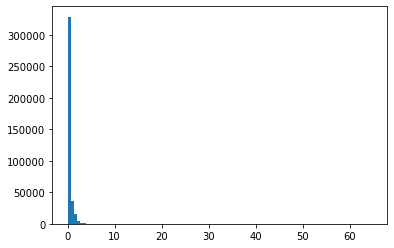

In [8]:
print(f'stoped training, best nmi={best_nmi}, at layer={best_layer}')

plt.hist(best_Z[best_Z > 0].cpu().detach().numpy(), 100);

In [22]:
threshs=[ 0.125, 0.3,0.35, 0.4, 0.5, 0.75, 0.80, 0.90, 1.0]
for thresh in threshs:

    
    Z_pred = best_Z.cpu().detach().numpy() > thresh
#     model_saver.restore()
    print(f'Final nmi = {get_nmi(best_Z,thresh):.3f} for thresh= {thresh}')

Final nmi = 0.316 for thresh= 0.125
Final nmi = 0.362 for thresh= 0.3
Final nmi = 0.367 for thresh= 0.35
Final nmi = 0.365 for thresh= 0.4
Final nmi = 0.360 for thresh= 0.5
Final nmi = 0.271 for thresh= 0.75
Final nmi = 0.258 for thresh= 0.8
Final nmi = 0.216 for thresh= 0.9
Final nmi = 0.183 for thresh= 1.0


In [10]:

hidden_sizes = [128]    # hidden sizes of the GNN
weight_decay = 1e-2     # strength of L2 regularization on GNN weights
dropout = 0        # whether to use dropout
batch_norm = True       # whether to use batch norm
lr = 1e-3               # learning rate
max_epochs = 500        # number of epochs to train
display_step = 5       # how often to compute validation loss
balance_loss = True     # whether to use balanced loss
stochastic_loss = True  # whether to use stochastic or full-batch training
batch_size = 20000   


import numpy as np
niters = 30

In [23]:

best_thresh=0.35
best_layer = 40
print('best_layer: ', best_layer)
nmi_arr = [] 
for t in range(niters):
    best_nmi=0
    _, G = nocd.nn.models_deep.augment_graph_neighbors_with_degree(A)

    
    x_norm = normalize(X)  # node features
    x_norm = nocd.utils.to_sparse_tensor(x_norm).cuda()

    sampler = nocd.sampler.get_edge_sampler(A, batch_size, batch_size, num_workers=5)
    gnn = nocd.nn.models_deep.GCNRes(x_norm.shape[1], hidden_sizes, K, batch_norm=batch_norm, dropout=dropout, layer_num=best_layer, g=G, d=2).cuda()
    adj_norm = gnn.normalize_adj(A)
    decoder = nocd.nn.BerpoDecoder(N, A.nnz, balance_loss=balance_loss)
    opt = torch.optim.Adam(gnn.parameters(), lr=lr)

    val_loss = np.inf
    validation_fn = lambda: val_loss
    early_stopping = nocd.train.NoImprovementStopping(validation_fn, patience=10)
    model_saver = nocd.train.ModelSaver(gnn)
    

    for epoch, batch in enumerate(sampler):
        if epoch > max_epochs:
            break
        if epoch % 25 == 0:
            with torch.no_grad():
                gnn.eval()
                # Compute validation loss
                Z = F.relu(gnn(x_norm))
                val_loss = decoder.loss_full(Z, A)
                val=get_nmi(Z,best_thresh)
                if(val> best_nmi):
                    best_nmi = val
                    best_Z = Z.detach().clone()
                    
                    
                    print(f'Epoch {epoch:4d}, loss.full = {val_loss:.4f}, nmi = {val:.2f}')

                # Check if it's time for early stopping / to save the model
                early_stopping.next_step()
                if early_stopping.should_save():
                    model_saver.save()
                if early_stopping.should_stop():
                    print(f'Breaking due to early stopping at epoch {epoch}')
                    break

        # Training step
        gnn.train()
        opt.zero_grad()
        Z = F.relu(gnn(x_norm))
        ones_idx, zeros_idx = batch
        if stochastic_loss:
            loss = decoder.loss_batch(Z, ones_idx, zeros_idx)
        else:
            loss = decoder.loss_full(Z, A)
        loss += nocd.utils.l2_reg_loss(gnn, scale=weight_decay)
        loss.backward()
        opt.step()
        
    nmi_arr.append(best_nmi)
    
    print('iter: ',t)

print("Done")



best_layer:  40


100%|██████████| 14927/14927 [00:00<00:00, 26757.03it/s]


Epoch    0, loss.full = 0.8827, nmi = 0.08
Epoch   25, loss.full = 0.2685, nmi = 0.28
Epoch   50, loss.full = 0.2486, nmi = 0.28
Epoch   75, loss.full = 0.2319, nmi = 0.33
Epoch  125, loss.full = 0.2338, nmi = 0.33
Epoch  150, loss.full = 0.2379, nmi = 0.33
Epoch  175, loss.full = 0.2277, nmi = 0.34
Epoch  200, loss.full = 0.2252, nmi = 0.35
Epoch  225, loss.full = 0.2360, nmi = 0.36
Epoch  250, loss.full = 0.2240, nmi = 0.37
Epoch  275, loss.full = 0.2264, nmi = 0.38
Epoch  325, loss.full = 0.2256, nmi = 0.38
Epoch  350, loss.full = 0.2296, nmi = 0.39
iter:  0


100%|██████████| 14927/14927 [00:00<00:00, 27145.46it/s]


Epoch    0, loss.full = 0.6173, nmi = 0.07
Epoch   25, loss.full = 0.2729, nmi = 0.28
Epoch   50, loss.full = 0.2525, nmi = 0.29
Epoch   75, loss.full = 0.2393, nmi = 0.31
Epoch  100, loss.full = 0.2358, nmi = 0.33
Epoch  125, loss.full = 0.2374, nmi = 0.34
Epoch  150, loss.full = 0.2317, nmi = 0.36
Epoch  225, loss.full = 0.2292, nmi = 0.36
Epoch  275, loss.full = 0.2302, nmi = 0.36
Epoch  325, loss.full = 0.2332, nmi = 0.37
Epoch  375, loss.full = 0.2307, nmi = 0.37
Epoch  400, loss.full = 0.2441, nmi = 0.38
Epoch  425, loss.full = 0.2297, nmi = 0.39
iter:  1


100%|██████████| 14927/14927 [00:00<00:00, 27476.37it/s]


Epoch    0, loss.full = 0.6041, nmi = 0.11
Epoch   25, loss.full = 0.2698, nmi = 0.27
Epoch   50, loss.full = 0.2469, nmi = 0.28
Epoch  125, loss.full = 0.2394, nmi = 0.28
Epoch  150, loss.full = 0.2313, nmi = 0.28
Epoch  175, loss.full = 0.2343, nmi = 0.29
Epoch  200, loss.full = 0.2359, nmi = 0.29
Epoch  225, loss.full = 0.2328, nmi = 0.30
Epoch  275, loss.full = 0.2303, nmi = 0.31
Epoch  300, loss.full = 0.2431, nmi = 0.31
Epoch  350, loss.full = 0.2329, nmi = 0.32
Epoch  375, loss.full = 0.2293, nmi = 0.35
Epoch  400, loss.full = 0.2261, nmi = 0.38
iter:  2


100%|██████████| 14927/14927 [00:00<00:00, 27305.66it/s]


Epoch    0, loss.full = 0.5678, nmi = 0.14
Epoch   25, loss.full = 0.2648, nmi = 0.27
Epoch   50, loss.full = 0.2475, nmi = 0.31
Epoch   75, loss.full = 0.2365, nmi = 0.31
Epoch  125, loss.full = 0.2296, nmi = 0.34
Epoch  225, loss.full = 0.2296, nmi = 0.34
Epoch  250, loss.full = 0.2358, nmi = 0.35
iter:  3


100%|██████████| 14927/14927 [00:00<00:00, 27119.72it/s]


Epoch    0, loss.full = 0.6431, nmi = 0.07
Epoch   25, loss.full = 0.2660, nmi = 0.32
Epoch   50, loss.full = 0.2414, nmi = 0.33
Epoch   75, loss.full = 0.2248, nmi = 0.34
Epoch  300, loss.full = 0.2345, nmi = 0.34
Epoch  325, loss.full = 0.2253, nmi = 0.35
Epoch  375, loss.full = 0.2248, nmi = 0.35
Epoch  425, loss.full = 0.2284, nmi = 0.37
Breaking due to early stopping at epoch 500
iter:  4


100%|██████████| 14927/14927 [00:00<00:00, 27676.42it/s]


Epoch    0, loss.full = 0.6064, nmi = 0.07
Epoch   25, loss.full = 0.2545, nmi = 0.33
Epoch   50, loss.full = 0.2399, nmi = 0.38
Breaking due to early stopping at epoch 425
iter:  5


100%|██████████| 14927/14927 [00:00<00:00, 27446.67it/s]


Epoch    0, loss.full = 1.1611, nmi = 0.06
Epoch   25, loss.full = 0.2812, nmi = 0.28
Epoch   50, loss.full = 0.2513, nmi = 0.30
Epoch   75, loss.full = 0.2362, nmi = 0.32
Epoch  100, loss.full = 0.2269, nmi = 0.32
iter:  6


100%|██████████| 14927/14927 [00:00<00:00, 27468.73it/s]


Epoch    0, loss.full = 0.5731, nmi = 0.13
Epoch   25, loss.full = 0.2674, nmi = 0.31
Epoch   50, loss.full = 0.2448, nmi = 0.31
Epoch  250, loss.full = 0.2419, nmi = 0.32
Epoch  450, loss.full = 0.2193, nmi = 0.33
iter:  7


100%|██████████| 14927/14927 [00:00<00:00, 27494.98it/s]


Epoch    0, loss.full = 0.6591, nmi = 0.08
Epoch   25, loss.full = 0.2750, nmi = 0.27
Epoch   50, loss.full = 0.2527, nmi = 0.29
Epoch   75, loss.full = 0.2384, nmi = 0.31
Epoch  125, loss.full = 0.2257, nmi = 0.33
Epoch  175, loss.full = 0.2280, nmi = 0.35
Epoch  275, loss.full = 0.2406, nmi = 0.35
Epoch  300, loss.full = 0.2396, nmi = 0.38
Epoch  375, loss.full = 0.2297, nmi = 0.38
Epoch  400, loss.full = 0.2293, nmi = 0.38
Breaking due to early stopping at epoch 400
iter:  8


100%|██████████| 14927/14927 [00:00<00:00, 33496.88it/s]


Epoch    0, loss.full = 0.8589, nmi = 0.04
Epoch   25, loss.full = 0.2729, nmi = 0.27
Epoch   50, loss.full = 0.2484, nmi = 0.32
Epoch   75, loss.full = 0.2362, nmi = 0.34
Epoch  100, loss.full = 0.2334, nmi = 0.35
Epoch  200, loss.full = 0.2307, nmi = 0.36
Epoch  400, loss.full = 0.2618, nmi = 0.38
iter:  9


100%|██████████| 14927/14927 [00:00<00:00, 32617.58it/s]


Epoch    0, loss.full = 0.6486, nmi = 0.12
Epoch   25, loss.full = 0.2614, nmi = 0.29
Epoch   50, loss.full = 0.2376, nmi = 0.31
Epoch   75, loss.full = 0.2281, nmi = 0.31
Epoch  100, loss.full = 0.2456, nmi = 0.33
Epoch  325, loss.full = 0.2468, nmi = 0.33
Breaking due to early stopping at epoch 350
iter:  10


100%|██████████| 14927/14927 [00:00<00:00, 27162.54it/s]


Epoch    0, loss.full = 0.8941, nmi = 0.05
Epoch   25, loss.full = 0.2748, nmi = 0.28
Epoch   50, loss.full = 0.2487, nmi = 0.30
Epoch   75, loss.full = 0.2332, nmi = 0.31
Epoch  175, loss.full = 0.2287, nmi = 0.32
Epoch  225, loss.full = 0.2352, nmi = 0.33
Epoch  250, loss.full = 0.2329, nmi = 0.34
Epoch  275, loss.full = 0.2417, nmi = 0.35
Epoch  300, loss.full = 0.2240, nmi = 0.36
Epoch  450, loss.full = 0.2293, nmi = 0.39
Epoch  475, loss.full = 0.2338, nmi = 0.41
iter:  11


100%|██████████| 14927/14927 [00:00<00:00, 34911.68it/s]


Epoch    0, loss.full = 0.6525, nmi = 0.04
Epoch   25, loss.full = 0.2555, nmi = 0.32
Epoch   50, loss.full = 0.2374, nmi = 0.33
Epoch  175, loss.full = 0.2277, nmi = 0.35
Epoch  200, loss.full = 0.2300, nmi = 0.36
Epoch  225, loss.full = 0.2302, nmi = 0.37
Epoch  275, loss.full = 0.2378, nmi = 0.39
iter:  12


100%|██████████| 14927/14927 [00:00<00:00, 27100.91it/s]


Epoch    0, loss.full = 0.6042, nmi = 0.10
Epoch   25, loss.full = 0.2545, nmi = 0.31
Epoch   50, loss.full = 0.2381, nmi = 0.32
Epoch   75, loss.full = 0.2282, nmi = 0.33
Epoch  200, loss.full = 0.2309, nmi = 0.34
Epoch  250, loss.full = 0.2435, nmi = 0.36
Breaking due to early stopping at epoch 375
iter:  13


100%|██████████| 14927/14927 [00:00<00:00, 27067.28it/s]


Epoch    0, loss.full = 0.6208, nmi = 0.13
Epoch   25, loss.full = 0.2738, nmi = 0.35
Epoch   50, loss.full = 0.2628, nmi = 0.36
Epoch  350, loss.full = 0.2249, nmi = 0.37
iter:  14


100%|██████████| 14927/14927 [00:00<00:00, 28766.78it/s]


Epoch    0, loss.full = 0.5723, nmi = 0.07
Epoch   25, loss.full = 0.2663, nmi = 0.30
Epoch   50, loss.full = 0.2457, nmi = 0.32
Epoch   75, loss.full = 0.2350, nmi = 0.32
Epoch  125, loss.full = 0.2291, nmi = 0.34
Epoch  150, loss.full = 0.2301, nmi = 0.35
Epoch  175, loss.full = 0.2398, nmi = 0.36
Epoch  200, loss.full = 0.2426, nmi = 0.36
Epoch  250, loss.full = 0.2357, nmi = 0.37
Epoch  275, loss.full = 0.2361, nmi = 0.37
Breaking due to early stopping at epoch 400
iter:  15


100%|██████████| 14927/14927 [00:00<00:00, 29627.44it/s]


Epoch    0, loss.full = 0.8744, nmi = 0.08
Epoch   25, loss.full = 0.2853, nmi = 0.30
Epoch  175, loss.full = 0.2271, nmi = 0.33
Epoch  250, loss.full = 0.2374, nmi = 0.34
Epoch  300, loss.full = 0.2318, nmi = 0.34
Epoch  400, loss.full = 0.2307, nmi = 0.34
Epoch  425, loss.full = 0.2265, nmi = 0.36
Breaking due to early stopping at epoch 425
iter:  16


100%|██████████| 14927/14927 [00:00<00:00, 27166.22it/s]


Epoch    0, loss.full = 0.6012, nmi = 0.14
Epoch   25, loss.full = 0.2591, nmi = 0.29
Epoch   50, loss.full = 0.2361, nmi = 0.32
Epoch   75, loss.full = 0.2359, nmi = 0.32
Epoch  100, loss.full = 0.2252, nmi = 0.33
Epoch  125, loss.full = 0.2254, nmi = 0.35
Epoch  175, loss.full = 0.2297, nmi = 0.37
Epoch  200, loss.full = 0.2452, nmi = 0.40
Epoch  275, loss.full = 0.2326, nmi = 0.41
Breaking due to early stopping at epoch 375
iter:  17


100%|██████████| 14927/14927 [00:00<00:00, 27473.78it/s]


Epoch    0, loss.full = 0.7026, nmi = 0.04
Epoch   25, loss.full = 0.2624, nmi = 0.28
Epoch   50, loss.full = 0.2395, nmi = 0.28
Epoch  250, loss.full = 0.2341, nmi = 0.31
Epoch  400, loss.full = 0.2351, nmi = 0.35
Epoch  425, loss.full = 0.2233, nmi = 0.36
Epoch  450, loss.full = 0.2255, nmi = 0.36
iter:  18


100%|██████████| 14927/14927 [00:00<00:00, 27772.42it/s]


Epoch    0, loss.full = 0.7322, nmi = 0.08
Epoch   25, loss.full = 0.2672, nmi = 0.29
Epoch   50, loss.full = 0.2478, nmi = 0.31
Epoch   75, loss.full = 0.2341, nmi = 0.34
Epoch  100, loss.full = 0.2323, nmi = 0.35
Epoch  125, loss.full = 0.2391, nmi = 0.36
Epoch  150, loss.full = 0.2390, nmi = 0.36
Epoch  175, loss.full = 0.2280, nmi = 0.36
Epoch  200, loss.full = 0.2364, nmi = 0.36
Epoch  225, loss.full = 0.2366, nmi = 0.37
Epoch  325, loss.full = 0.2272, nmi = 0.39
iter:  19


100%|██████████| 14927/14927 [00:00<00:00, 33491.52it/s]


Epoch    0, loss.full = 0.6519, nmi = 0.09
Epoch   25, loss.full = 0.2592, nmi = 0.31
Epoch   50, loss.full = 0.2433, nmi = 0.33
Epoch   75, loss.full = 0.2294, nmi = 0.36
Epoch  175, loss.full = 0.2292, nmi = 0.36
Epoch  200, loss.full = 0.2281, nmi = 0.38
iter:  20


100%|██████████| 14927/14927 [00:00<00:00, 27100.13it/s]


Epoch    0, loss.full = 0.7327, nmi = 0.13
Epoch   25, loss.full = 0.2760, nmi = 0.31
Epoch   50, loss.full = 0.2511, nmi = 0.33
Epoch  150, loss.full = 0.2358, nmi = 0.34
Epoch  200, loss.full = 0.2366, nmi = 0.35
Epoch  275, loss.full = 0.2378, nmi = 0.35
Epoch  350, loss.full = 0.2383, nmi = 0.35
Epoch  375, loss.full = 0.2350, nmi = 0.37
Epoch  400, loss.full = 0.2359, nmi = 0.37
Epoch  425, loss.full = 0.2318, nmi = 0.38
Epoch  475, loss.full = 0.2323, nmi = 0.39
iter:  21


100%|██████████| 14927/14927 [00:00<00:00, 32863.56it/s]


Epoch    0, loss.full = 0.7364, nmi = 0.05
Epoch   25, loss.full = 0.2917, nmi = 0.27
Epoch   50, loss.full = 0.2467, nmi = 0.30
Epoch  100, loss.full = 0.2277, nmi = 0.31
Epoch  125, loss.full = 0.2273, nmi = 0.32
Epoch  150, loss.full = 0.2312, nmi = 0.33
Epoch  250, loss.full = 0.2257, nmi = 0.34
Epoch  300, loss.full = 0.2359, nmi = 0.35
Epoch  375, loss.full = 0.2437, nmi = 0.39
Breaking due to early stopping at epoch 475
iter:  22


100%|██████████| 14927/14927 [00:00<00:00, 27227.21it/s]


Epoch    0, loss.full = 0.7416, nmi = 0.10
Epoch   25, loss.full = 0.2670, nmi = 0.30
Epoch   50, loss.full = 0.2444, nmi = 0.33
Epoch   75, loss.full = 0.2377, nmi = 0.34
Epoch  125, loss.full = 0.2349, nmi = 0.35
Epoch  150, loss.full = 0.2475, nmi = 0.38
Epoch  225, loss.full = 0.2318, nmi = 0.39
Epoch  275, loss.full = 0.2335, nmi = 0.39
Epoch  300, loss.full = 0.2443, nmi = 0.40
Epoch  325, loss.full = 0.2535, nmi = 0.41
iter:  23


100%|██████████| 14927/14927 [00:00<00:00, 27158.91it/s]


Epoch    0, loss.full = 0.5661, nmi = 0.10
Epoch   25, loss.full = 0.2623, nmi = 0.29
Epoch   50, loss.full = 0.2429, nmi = 0.30
Epoch  175, loss.full = 0.2309, nmi = 0.32
Epoch  200, loss.full = 0.2295, nmi = 0.34
Epoch  250, loss.full = 0.2306, nmi = 0.35
Epoch  275, loss.full = 0.2308, nmi = 0.37
Epoch  475, loss.full = 0.2492, nmi = 0.38
Breaking due to early stopping at epoch 500
iter:  24


100%|██████████| 14927/14927 [00:00<00:00, 27248.45it/s]


Epoch    0, loss.full = 0.5174, nmi = 0.12
Epoch   25, loss.full = 0.2560, nmi = 0.26
Epoch   50, loss.full = 0.2317, nmi = 0.33
Epoch   75, loss.full = 0.2296, nmi = 0.34
Epoch  100, loss.full = 0.2237, nmi = 0.36
Epoch  125, loss.full = 0.2333, nmi = 0.37
Epoch  150, loss.full = 0.2327, nmi = 0.39
Epoch  200, loss.full = 0.2362, nmi = 0.40
Breaking due to early stopping at epoch 375
iter:  25


100%|██████████| 14927/14927 [00:00<00:00, 27251.04it/s]


Epoch    0, loss.full = 0.7002, nmi = 0.08
Epoch   25, loss.full = 0.2680, nmi = 0.31
Epoch  150, loss.full = 0.2317, nmi = 0.33
Epoch  175, loss.full = 0.2342, nmi = 0.34
Epoch  250, loss.full = 0.2602, nmi = 0.37
Breaking due to early stopping at epoch 400
iter:  26


100%|██████████| 14927/14927 [00:00<00:00, 27533.96it/s]


Epoch    0, loss.full = 0.8850, nmi = 0.05
Epoch   25, loss.full = 0.2670, nmi = 0.29
Epoch   75, loss.full = 0.2322, nmi = 0.31
Epoch  100, loss.full = 0.2298, nmi = 0.31
Epoch  125, loss.full = 0.2274, nmi = 0.32
Epoch  150, loss.full = 0.2332, nmi = 0.33
Epoch  175, loss.full = 0.2329, nmi = 0.34
Epoch  250, loss.full = 0.2223, nmi = 0.35
Epoch  275, loss.full = 0.2402, nmi = 0.39
Epoch  500, loss.full = 0.2530, nmi = 0.40
iter:  27


100%|██████████| 14927/14927 [00:00<00:00, 27436.71it/s]


Epoch    0, loss.full = 0.6180, nmi = 0.07
Epoch   25, loss.full = 0.2619, nmi = 0.31
Epoch   50, loss.full = 0.2383, nmi = 0.33
Epoch  250, loss.full = 0.2297, nmi = 0.33
Epoch  375, loss.full = 0.2359, nmi = 0.34
Epoch  400, loss.full = 0.2300, nmi = 0.37
Epoch  475, loss.full = 0.2287, nmi = 0.38
iter:  28


100%|██████████| 14927/14927 [00:00<00:00, 33754.75it/s]


Epoch    0, loss.full = 0.5491, nmi = 0.12
Epoch   25, loss.full = 0.2540, nmi = 0.30
Epoch   50, loss.full = 0.2323, nmi = 0.33
Epoch   75, loss.full = 0.2356, nmi = 0.34
Epoch  125, loss.full = 0.2330, nmi = 0.34
Epoch  175, loss.full = 0.2261, nmi = 0.35
Epoch  250, loss.full = 0.2333, nmi = 0.35
Epoch  275, loss.full = 0.2327, nmi = 0.36
Epoch  325, loss.full = 0.2267, nmi = 0.36
Epoch  400, loss.full = 0.2257, nmi = 0.37
Epoch  450, loss.full = 0.2256, nmi = 0.38
Epoch  500, loss.full = 0.2307, nmi = 0.38
iter:  29


100%|██████████| 14927/14927 [00:00<00:00, 27052.86it/s]


Epoch    0, loss.full = 0.6086, nmi = 0.10
Epoch   25, loss.full = 0.2630, nmi = 0.29
Epoch   50, loss.full = 0.2433, nmi = 0.30
Epoch  175, loss.full = 0.2320, nmi = 0.31
Epoch  200, loss.full = 0.2277, nmi = 0.34
Epoch  225, loss.full = 0.2337, nmi = 0.37
Epoch  250, loss.full = 0.2463, nmi = 0.38
Epoch  275, loss.full = 0.2391, nmi = 0.40
Epoch  300, loss.full = 0.2310, nmi = 0.41
Epoch  375, loss.full = 0.2290, nmi = 0.41
Breaking due to early stopping at epoch 400
iter:  30


100%|██████████| 14927/14927 [00:00<00:00, 34552.64it/s]


Epoch    0, loss.full = 0.9117, nmi = 0.11
Epoch   25, loss.full = 0.2920, nmi = 0.30
Epoch   50, loss.full = 0.2611, nmi = 0.30
Epoch   75, loss.full = 0.2407, nmi = 0.34
Epoch  100, loss.full = 0.2342, nmi = 0.35
Epoch  125, loss.full = 0.2320, nmi = 0.35
Epoch  150, loss.full = 0.2309, nmi = 0.37
Epoch  450, loss.full = 0.2464, nmi = 0.37
Epoch  500, loss.full = 0.2344, nmi = 0.39
iter:  31


100%|██████████| 14927/14927 [00:00<00:00, 34643.76it/s]


Epoch    0, loss.full = 0.7648, nmi = 0.11
Epoch   25, loss.full = 0.2693, nmi = 0.32
Epoch  100, loss.full = 0.2289, nmi = 0.33
Epoch  125, loss.full = 0.2288, nmi = 0.33
Epoch  150, loss.full = 0.2339, nmi = 0.34
Epoch  225, loss.full = 0.2393, nmi = 0.36
Epoch  425, loss.full = 0.2640, nmi = 0.37
Epoch  450, loss.full = 0.2497, nmi = 0.42
Epoch  500, loss.full = 0.2481, nmi = 0.42
iter:  32


100%|██████████| 14927/14927 [00:00<00:00, 27115.78it/s]


Epoch    0, loss.full = 0.5543, nmi = 0.12
Epoch   25, loss.full = 0.2563, nmi = 0.29
Epoch   50, loss.full = 0.2326, nmi = 0.31
Epoch   75, loss.full = 0.2242, nmi = 0.32
Epoch  125, loss.full = 0.2256, nmi = 0.33
Epoch  175, loss.full = 0.2298, nmi = 0.35
Epoch  200, loss.full = 0.2331, nmi = 0.35
Epoch  225, loss.full = 0.2222, nmi = 0.36
iter:  33


100%|██████████| 14927/14927 [00:00<00:00, 27899.24it/s]


Epoch    0, loss.full = 0.6041, nmi = 0.10
Epoch   25, loss.full = 0.2636, nmi = 0.34
Epoch  325, loss.full = 0.2363, nmi = 0.35
Breaking due to early stopping at epoch 450
iter:  34


100%|██████████| 14927/14927 [00:00<00:00, 27751.15it/s]


Epoch    0, loss.full = 0.8220, nmi = 0.12
Epoch   25, loss.full = 0.2752, nmi = 0.27
Epoch   50, loss.full = 0.2506, nmi = 0.30
Epoch   75, loss.full = 0.2362, nmi = 0.31
Epoch  125, loss.full = 0.2276, nmi = 0.33
Epoch  175, loss.full = 0.2324, nmi = 0.34
Epoch  200, loss.full = 0.2332, nmi = 0.35
Epoch  250, loss.full = 0.3205, nmi = 0.37
Epoch  275, loss.full = 0.2451, nmi = 0.39
Epoch  325, loss.full = 0.2317, nmi = 0.40
Breaking due to early stopping at epoch 400
iter:  35


100%|██████████| 14927/14927 [00:00<00:00, 27344.68it/s]


Epoch    0, loss.full = 0.5429, nmi = 0.11
Epoch   25, loss.full = 0.2630, nmi = 0.26
Epoch   50, loss.full = 0.2361, nmi = 0.30
Epoch   75, loss.full = 0.2301, nmi = 0.31
Epoch  150, loss.full = 0.2276, nmi = 0.31
Epoch  175, loss.full = 0.2316, nmi = 0.33
iter:  36


100%|██████████| 14927/14927 [00:00<00:00, 27223.35it/s]


Epoch    0, loss.full = 0.5874, nmi = 0.13
Epoch   25, loss.full = 0.2786, nmi = 0.25
Epoch   50, loss.full = 0.2525, nmi = 0.28
Epoch   75, loss.full = 0.2397, nmi = 0.29
Epoch  100, loss.full = 0.2328, nmi = 0.32
Epoch  125, loss.full = 0.2417, nmi = 0.32
Epoch  150, loss.full = 0.2279, nmi = 0.33
Epoch  200, loss.full = 0.2374, nmi = 0.34
Epoch  250, loss.full = 0.2348, nmi = 0.38
Epoch  275, loss.full = 0.2330, nmi = 0.39
Epoch  300, loss.full = 0.2323, nmi = 0.40
iter:  37


100%|██████████| 14927/14927 [00:00<00:00, 30197.95it/s]


Epoch    0, loss.full = 0.5592, nmi = 0.06
Epoch   25, loss.full = 0.2762, nmi = 0.28
Epoch   50, loss.full = 0.2422, nmi = 0.29
Epoch   75, loss.full = 0.2337, nmi = 0.29
Epoch  250, loss.full = 0.2314, nmi = 0.31
Epoch  300, loss.full = 0.2263, nmi = 0.31
Epoch  475, loss.full = 0.2250, nmi = 0.32
Epoch  500, loss.full = 0.2234, nmi = 0.34
iter:  38


100%|██████████| 14927/14927 [00:00<00:00, 27231.25it/s]


Epoch    0, loss.full = 0.4950, nmi = 0.05
Epoch   25, loss.full = 0.2651, nmi = 0.28
Epoch  100, loss.full = 0.2542, nmi = 0.30
Epoch  150, loss.full = 0.2277, nmi = 0.32
Epoch  200, loss.full = 0.2315, nmi = 0.32
Epoch  225, loss.full = 0.2252, nmi = 0.33
Epoch  250, loss.full = 0.2487, nmi = 0.35
Epoch  275, loss.full = 0.2311, nmi = 0.37
Epoch  300, loss.full = 0.2349, nmi = 0.37
Epoch  350, loss.full = 0.2361, nmi = 0.37
iter:  39


100%|██████████| 14927/14927 [00:00<00:00, 33620.36it/s]


Epoch    0, loss.full = 0.5303, nmi = 0.20
Epoch   25, loss.full = 0.2707, nmi = 0.29
Epoch   50, loss.full = 0.2372, nmi = 0.35
Epoch  150, loss.full = 0.2309, nmi = 0.37
Epoch  225, loss.full = 0.2333, nmi = 0.38
Epoch  250, loss.full = 0.2349, nmi = 0.39
Epoch  300, loss.full = 0.2271, nmi = 0.41
Epoch  325, loss.full = 0.2365, nmi = 0.42
Breaking due to early stopping at epoch 450
iter:  40


100%|██████████| 14927/14927 [00:00<00:00, 27569.14it/s]


Epoch    0, loss.full = 0.4841, nmi = 0.14
Epoch   25, loss.full = 0.2557, nmi = 0.32
Epoch  175, loss.full = 0.2276, nmi = 0.32
Epoch  325, loss.full = 0.2360, nmi = 0.33
Epoch  350, loss.full = 0.2208, nmi = 0.33
Epoch  475, loss.full = 0.2206, nmi = 0.33
Epoch  500, loss.full = 0.2362, nmi = 0.34
iter:  41


100%|██████████| 14927/14927 [00:00<00:00, 27277.27it/s]


Epoch    0, loss.full = 0.6640, nmi = 0.12
Epoch   25, loss.full = 0.2722, nmi = 0.29
Epoch  225, loss.full = 0.2625, nmi = 0.33
Epoch  250, loss.full = 0.2516, nmi = 0.35
Epoch  275, loss.full = 0.2414, nmi = 0.35
Epoch  300, loss.full = 0.2343, nmi = 0.36
Epoch  325, loss.full = 0.2312, nmi = 0.39
Epoch  375, loss.full = 0.2293, nmi = 0.39
Epoch  450, loss.full = 0.2342, nmi = 0.39
Epoch  475, loss.full = 0.2288, nmi = 0.40
iter:  42


100%|██████████| 14927/14927 [00:00<00:00, 27652.87it/s]


Epoch    0, loss.full = 0.6763, nmi = 0.13
Epoch   25, loss.full = 0.2699, nmi = 0.33
Epoch   50, loss.full = 0.2525, nmi = 0.34
Epoch  150, loss.full = 0.2370, nmi = 0.36
Epoch  350, loss.full = 0.2291, nmi = 0.36
iter:  43


100%|██████████| 14927/14927 [00:00<00:00, 27364.15it/s]


Epoch    0, loss.full = 0.7633, nmi = 0.10
Epoch   25, loss.full = 0.2663, nmi = 0.30
Epoch   50, loss.full = 0.2405, nmi = 0.31
Epoch   75, loss.full = 0.2308, nmi = 0.33
Epoch  100, loss.full = 0.2282, nmi = 0.33
Epoch  150, loss.full = 0.2289, nmi = 0.35
Epoch  175, loss.full = 0.2227, nmi = 0.37
Epoch  275, loss.full = 0.2302, nmi = 0.37
Epoch  300, loss.full = 0.2335, nmi = 0.38
Epoch  325, loss.full = 0.2325, nmi = 0.38
Epoch  400, loss.full = 0.2306, nmi = 0.39
Epoch  425, loss.full = 0.2269, nmi = 0.39
Breaking due to early stopping at epoch 450
iter:  44


100%|██████████| 14927/14927 [00:00<00:00, 27261.52it/s]


Epoch    0, loss.full = 0.6151, nmi = 0.12
Epoch   25, loss.full = 0.2662, nmi = 0.30
Epoch   50, loss.full = 0.2372, nmi = 0.34
Epoch   75, loss.full = 0.2381, nmi = 0.34
Epoch  100, loss.full = 0.2264, nmi = 0.36
Epoch  150, loss.full = 0.2232, nmi = 0.36
Epoch  200, loss.full = 0.2381, nmi = 0.36
Epoch  275, loss.full = 0.2392, nmi = 0.38
Epoch  300, loss.full = 0.2314, nmi = 0.38
Epoch  350, loss.full = 0.2319, nmi = 0.39
Epoch  400, loss.full = 0.2529, nmi = 0.41
Breaking due to early stopping at epoch 425
iter:  45


100%|██████████| 14927/14927 [00:00<00:00, 34399.24it/s]


Epoch    0, loss.full = 0.5710, nmi = 0.11
Epoch   25, loss.full = 0.2540, nmi = 0.30
Epoch   50, loss.full = 0.2349, nmi = 0.30
Epoch   75, loss.full = 0.2384, nmi = 0.31
Epoch  125, loss.full = 0.2297, nmi = 0.32
Epoch  150, loss.full = 0.2408, nmi = 0.36
Epoch  175, loss.full = 0.2333, nmi = 0.36
Epoch  225, loss.full = 0.2419, nmi = 0.36
Epoch  250, loss.full = 0.2272, nmi = 0.38
Epoch  400, loss.full = 0.2315, nmi = 0.39
Epoch  500, loss.full = 0.2328, nmi = 0.39
iter:  46


100%|██████████| 14927/14927 [00:00<00:00, 26721.47it/s]


Epoch    0, loss.full = 0.6910, nmi = 0.12
Epoch   25, loss.full = 0.2613, nmi = 0.30
Epoch  100, loss.full = 0.2430, nmi = 0.31
Epoch  200, loss.full = 0.2405, nmi = 0.32
Epoch  225, loss.full = 0.2299, nmi = 0.33
Epoch  250, loss.full = 0.2320, nmi = 0.33
Epoch  400, loss.full = 0.2407, nmi = 0.36
Epoch  425, loss.full = 0.2304, nmi = 0.38
iter:  47


100%|██████████| 14927/14927 [00:00<00:00, 27124.98it/s]


Epoch    0, loss.full = 0.6289, nmi = 0.05
Epoch   25, loss.full = 0.2656, nmi = 0.32
Epoch   50, loss.full = 0.2470, nmi = 0.34
Epoch  150, loss.full = 0.2294, nmi = 0.35
Epoch  225, loss.full = 0.2344, nmi = 0.35
Epoch  250, loss.full = 0.2257, nmi = 0.36
Epoch  300, loss.full = 0.2345, nmi = 0.37
Epoch  375, loss.full = 0.2320, nmi = 0.38
Breaking due to early stopping at epoch 400
iter:  48


100%|██████████| 14927/14927 [00:00<00:00, 27092.87it/s]


Epoch    0, loss.full = 0.6619, nmi = 0.13
Epoch   25, loss.full = 0.2621, nmi = 0.29
Epoch   50, loss.full = 0.2405, nmi = 0.33
Epoch  150, loss.full = 0.2382, nmi = 0.34
Epoch  200, loss.full = 0.2397, nmi = 0.34
Epoch  225, loss.full = 0.2434, nmi = 0.35
Epoch  350, loss.full = 0.2361, nmi = 0.36
Epoch  400, loss.full = 0.2301, nmi = 0.36
iter:  49
Done


In [19]:
min_nmi = np.min(nmi_arr)
max_nmi = np.max(nmi_arr)
mean_nmi =np.mean(nmi_arr)
std_nmi =np.std(nmi_arr)
print('layer: ', best_layer)
print('best thresh: ', best_thresh)
print('min, max, mean, std: ', min_nmi, max_nmi, mean_nmi, std_nmi)

layer:  40
best thresh:  0.35
min, max, mean, std:  0.34546553740288416 0.3961768246571638 0.37224352750306094 0.011888823189410022


# Analyzing the results

### Visualize the adjacency matrix sorted by the communities

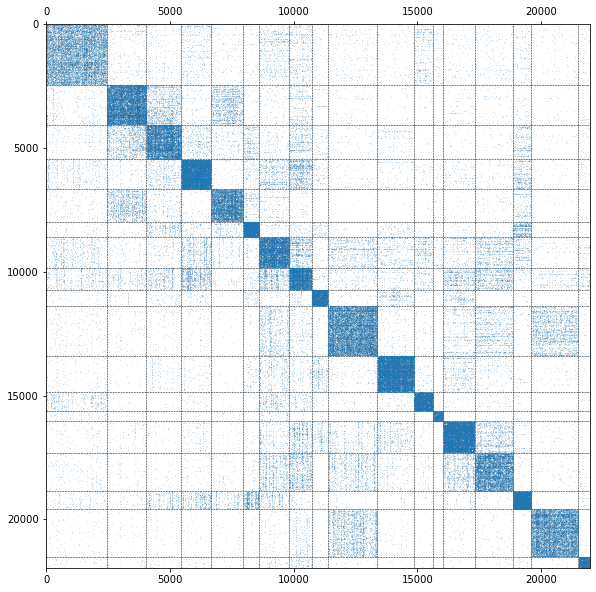

In [10]:
plt.figure(figsize=[10, 10])
z = np.argmax(Z_pred, 1)
o = np.argsort(z)
nocd.utils.plot_sparse_clustered_adjacency(A, K, z, o, markersize=0.05)

In [11]:
# Sizes of detected communities
print(Z_pred.sum(0))

[1922 1619 1786 1234 1783  873 1387 1979  786 2167 1653 1085  524 1564
 2442 1102 2602  628]


### Quantify quality of the communities based on unsupervised metrics.

Metrics:
* **Coverage**: what percentage of the edges is explained by at least one community? (i.e. if $(u, v)$ is an edge, both nodes share at least one community) Higher is better.
$$\textrm{Coverage}(C_1, ..., C_K) = \frac{1}{|E|}\sum_{u, v \in E} \mathbb{1}[z_u^T z_v > 0]$$


* **Density**: average density of the detected communities (weighted by community size). Higher is better.

$$\rho(C) = \frac{\text{# existing edges in $C$}}{\text{# of possible edges in $C$}}$$

$$\textrm{AvgDensity}(C_1, ..., C_K) = \frac{1}{\sum_i |C_i|}\sum_i \rho(C_i) \cdot |C_i|$$


* **Conductance**: average conductance of the detected communities (weighted by community size). Lower is better.

$$\textrm{outside}(C) = \sum_{u \in C, v \notin C} A_{uv}$$

$$\textrm{inside}(C) = \sum_{u \in C, v \in C, v \ne u} A_{uv}$$

$$\textrm{Conductance}(C) = \frac{\textrm{outside}(C)}{\textrm{inside}(C) + \textrm{outside}(C)}$$

$$\textrm{AvgConductance}(C_1, ..., C_K) = \frac{1}{\sum_i |C_i|}\sum_i \textrm{Conductance}(C_i) \cdot |C_i|$$


* **Clustering coefficient**: average clustering coefficient of the detected communities (weighted by community size). Higher is better.

$$\textrm{ClustCoef}(C) = \frac{\text{# existing triangles in $C$}}{\text{# of possible triangles in $C$}}$$

$$\textrm{AvgClustCoef}(C_1, ..., C_K) = \frac{1}{\sum_i |C_i|}\sum_i \textrm{ClustCoef}(C_i) \cdot |C_i|$$

Clustering coefficient & density of the entire graph

In [15]:
density_baseline = A.nnz / (N**2 - N)
num_triangles = (A @ A @ A).diagonal().sum() / 6
num_possible_triangles = (N - 2) * (N - 1) * N / 6
clust_coef_baseline = num_triangles / num_possible_triangles
print(f'Background (over the entire graph):\n'
      f' - density    = {density_baseline:.3e}\n'
      f' - clust_coef = {clust_coef_baseline:.3e}')

Background (over the entire graph):
 - density    = 4.014e-04
 - clust_coef = 5.733e-08


In [16]:
metrics = nocd.metrics.evaluate_unsupervised(Z_gt, A)
print(f"Ground truth communities:\n"
      f" - coverage    = {metrics['coverage']:.4f}\n"
      f" - conductance = {metrics['conductance']:.4f}\n"
      f" - density     = {metrics['density']:.3e}\n"
      f" - clust_coef  = {metrics['clustering_coef']:.3e}")

Ground truth communities:
 - coverage    = 0.9588
 - conductance = 0.3392
 - density     = 3.853e-03
 - clust_coef  = 9.145e-06


In [17]:
metrics = nocd.metrics.evaluate_unsupervised(Z_pred, A)
print(f"Predicted communities:\n"
      f" - coverage    = {metrics['coverage']:.4f}\n"
      f" - conductance = {metrics['conductance']:.4f}\n"
      f" - density     = {metrics['density']:.3e}\n"
      f" - clust_coef  = {metrics['clustering_coef']:.3e}")

Predicted communities:
 - coverage    = 0.9267
 - conductance = 0.2358
 - density     = 4.863e-03
 - clust_coef  = 1.094e-05


The detected partition has lower conductance / higher density / higher clustering coefficient than the GT communities.